In [31]:
"""
データ取得
ChEMBLとBindingDBのデータを取得し、EC50の値を取得する
EC50の値が500以下のものを1、500以上のものを0にする
"""
import pandas as pd
import numpy as np

ChEMBL_df = pd.read_csv("./data/ChEMBL.tsv", sep='\t')
ChEMBL_df = ChEMBL_df.dropna(subset=['Standard Relation'])
ChEMBL_df = ChEMBL_df.dropna(subset=['Standard Value'])
ChEMBL_df = ChEMBL_df[ChEMBL_df['Standard Relation'].str.contains("'='")]
ChEMBL_df = ChEMBL_df[ChEMBL_df['Standard Units'].str.contains('nM')]

BindingDB_df = pd.read_csv("./data/BindingDB.tsv", sep='\t')
BindingDB_df = BindingDB_df.dropna(subset=['EC50 (nM)'])
BindingDB_df = BindingDB_df[~BindingDB_df['EC50 (nM)'].str.contains('<|>')]
BindingDB_df['EC50 (nM)'] = BindingDB_df['EC50 (nM)'].astype(float)

# 両データフレームを結合
ChEMBL_df = ChEMBL_df[['Smiles', 'Standard Value']]
ChEMBL_df = ChEMBL_df.rename(columns={'Standard Value': 'EC50 (nM)'})
BindingDB_df = BindingDB_df[['Ligand SMILES', 'EC50 (nM)']]
BindingDB_df = BindingDB_df.rename(columns={'Ligand SMILES': 'Smiles'})

df = pd.concat([ChEMBL_df, BindingDB_df])

# 重複を削除
df = df.drop_duplicates(subset='Smiles')
df.to_csv('EC50.csv', index=False)

# 値が0のものを削除
df = df[df['EC50 (nM)'] != 0]

# EC50が100以下のものを1, 1000以上のものを0にし、それ以外を削除
df.loc[df['EC50 (nM)'] <= 70, 'values'] = 1
df.loc[df['EC50 (nM)'] >= 1000, 'values'] = 0
df = df[(df['values'] == 1) | (df['values'] == 0)]

df


,Smiles,EC50 (nM),values
0,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,2.90,1.0
1,Cc1nn(C)c(Oc2cccc(Cl)c2Cl)c1C(=O)N(Cc1cncs1)C(C)C,60.00,1.0
5,Cc1nn(C)c(Oc2cccc(Cl)c2Cl)c1C(=O)N1CCCCC1c1ccncc1,3140.00,0.0
7,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,1900000.00,0.0
9,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,0.16,1.0
...,...,...,...
1693,COc1cc(F)ccc1-c1ccncc1N(C[C@@H]1CCCO1)C(=O)c1c...,54.00,1.0
1694,CCC(=O)CN(C(=O)c1cc(nc(c1)C(F)(F)F)C(F)(F)F)c1...,54.00,1.0
1695,COc1cc(F)c(F)cc1-c1ccncc1N(CC(N)=O)C(=O)c1cc(n...,54.00,1.0
1696,COc1cc(F)ccc1-c1ccncc1N(C)C(=O)c1cc(cc(c1)S(=O...,54.00,1.0


In [32]:
"""
フィンガープリント作成
これを特徴量として使う
"""
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs import Sheridan

smiles_list = df['Smiles'].tolist()
# maccs = [AllChem.GetMACCSKeysFingerprint(Chem.MolFromSmiles(smiles)) for smiles in smiles_list]
# fp_df = pd.DataFrame(np.array(maccs, int))
ecfp = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 4, 4096) for smiles in smiles_list]
# fp_df = pd.concat([fp_df, pd.DataFrame(np.array(ecfp, int))], axis=1)
fp_df = pd.DataFrame(np.array(ecfp, int))

# 分散が0の変数を削除
fp_df = fp_df.loc[:, fp_df.var() != 0]

# 相関係数が高い変数を削除 -> 一つの構造による重複した寄与を削除
from dcekit.variable_selection import search_highly_correlated_variables
threshold_of_r = 0.95 #変数選択するときの相関係数の絶対値の閾値
corr_var = search_highly_correlated_variables(fp_df, threshold_of_r)
fp_df.drop(fp_df.columns[corr_var], axis=1, inplace=True)

# 5分子以上で出現するフィンガープリントのみを残す
fp_df = fp_df.loc[:, fp_df.sum() >= 5]

[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerator
[00:57:17] DEPRECATION WARNING: please use MorganGenerat

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [33]:
"""
変数が多く、過学習が起こりやすいため、変数選択を行う
bortaによる変数選択を行う
ランダムな特徴量を作成し、そのランダムな特徴量とオリジナルな特徴量をランダムフォレストで学習し、変数の重要度がランダムな特徴量よりも高いものを選択する
"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print(fp_df.shape)

X = fp_df
y = df['values'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# borutaによる変数選択
from boruta import BorutaPy

corr_list = []
for n in range(10000):
    shadow_features = np.random.rand(X_train.shape[0]).T
    corr = np.corrcoef(X_train, shadow_features,rowvar=False)[-1]
    corr = abs(corr[corr < 0.95])
    corr_list.append(corr.max())
    corr_array = np.array(corr_list)
    perc = 100 * (1-corr_array.max())

rf = RandomForestRegressor(n_estimators=100, random_state=0)

feat_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=0,
    alpha=0.05,
    max_iter=50,
    perc=perc,
    random_state=0
)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

feat_selector.fit(X_train.values, y_train.values)

X_train_selected = X_train.iloc[:, feat_selector.support_]
X_test_selected = X_test.iloc[:, feat_selector.support_]

print(X_train_selected.shape)

(1029, 2431)
(823, 348)


In [34]:
"""
学習にはランダムフォレストを用いる
決定木モデルを複数作成し、多数決で予測を行うもの
"""
# モデルの学習
rf.fit(X_train_selected, y_train)

# 2値分類の評価
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf.predict(X_test_selected)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.883495145631068
[[86 13]
 [11 96]]
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88        99
         1.0       0.88      0.90      0.89       107

    accuracy                           0.88       206
   macro avg       0.88      0.88      0.88       206
weighted avg       0.88      0.88      0.88       206



In [35]:
"""
予測したい構造のフィンガープリントを作成
"""
from rdkit.Chem import AllChem

def generate_peptides(n):
    print("Generating peptides...")

    amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    peptides = []

    def build_peptide(current_peptide):
        if len(current_peptide) == n:
            peptides.append(current_peptide)
            return
        for amino_acid in amino_acids:
            build_peptide(current_peptide + amino_acid)

    build_peptide('')

    print(f"Generated {len(peptides)} peptides.")
    
    return peptides

peptides = generate_peptides(3)
morgan_peptides = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromFASTA(peptide), 4, 4096) for peptide in peptides]
morgan_peptides_df = pd.DataFrame(np.array(morgan_peptides, int))

# fp_dfと同じ変数を持つようにする
morgan_peptides_df = morgan_peptides_df.loc[:, morgan_peptides_df.columns.isin(fp_df.columns)]

# モデルによる予測
morgan_peptides_df = morgan_peptides_df.iloc[:, feat_selector.support_]

result = rf.predict(morgan_peptides_df)
print(result)

Generating peptides...
Generated 8000 peptides.


[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerator
[01:27:29] DEPRECATION WARNING: please use MorganGenerat

[0.28813559 0.27457627 0.28813559 ... 0.29152542 0.34237288 0.25762712]


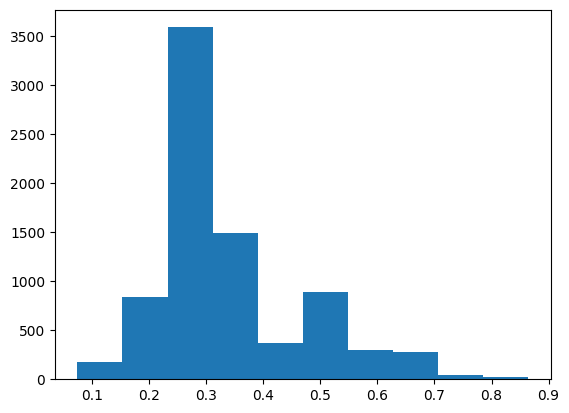

In [36]:
# resultを描画
import matplotlib.pyplot as plt

plt.hist(result)
plt.show()

In [37]:
# resultとペプチドの対応を表示
result_df = pd.DataFrame({'peptide': peptides, 'result': result})
result_df = pd.concat([result_df, morgan_peptides_df], axis=1)
# # 高い順にソート
result_df = result_df.sort_values('result', ascending=False)

result_df.to_csv('result.csv', index=False)

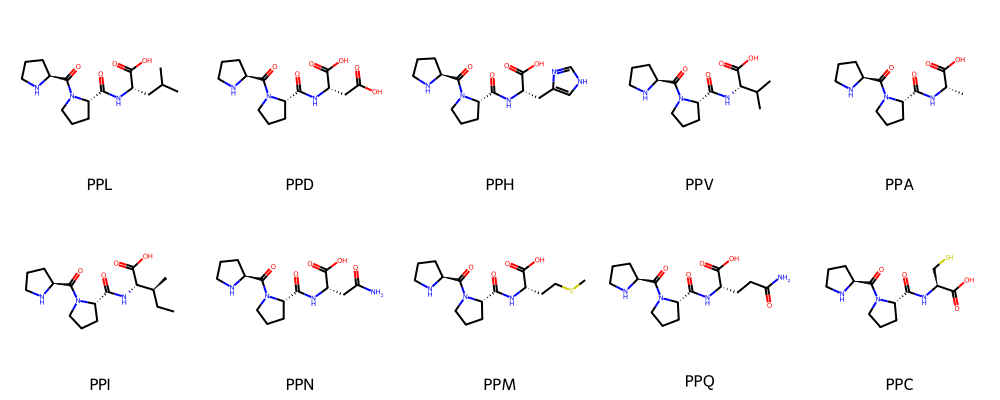

In [42]:
# result.csvから上位ペプチドを取得
import pandas as pd

result_df = pd.read_csv('result.csv')
high_score_peptides = result_df["peptide"].values[:10].tolist()

from rdkit import Chem
from rdkit.Chem import Draw

rdkit_high_score_peptides = [Chem.MolFromFASTA(peptide) for peptide in high_score_peptides]
Draw.MolsToGridImage(rdkit_high_score_peptides, molsPerRow=5, legends=high_score_peptides)


['22', '807', '1028', '1480', '1535', '2128', '2191', '2402', '2807', '2846', '2983', '3200']
{22: ((8, 4),), 117: ((14, 1),), 236: ((13, 3),), 242: ((7, 1),), 362: ((1, 1),), 507: ((15, 3),), 624: ((8, 2),), 689: ((9, 1),), 712: ((14, 3),), 736: ((15, 1),), 807: ((22, 0),), 837: ((14, 2),), 905: ((4, 3),), 982: ((8, 3),), 1028: ((5, 1), (12, 1)), 1188: ((9, 3),), 1325: ((4, 1), (11, 1)), 1480: ((13, 1),), 1482: ((18, 2),), 1507: ((0, 1),), 1535: ((2, 1),), 1608: ((11, 3),), 1624: ((16, 2),), 1750: ((1, 4),), 1844: ((16, 1),), 1847: ((19, 1),), 1891: ((12, 4),), 1917: ((3, 1), (10, 1), (17, 1)), 1934: ((15, 4),), 2022: ((5, 3),), 2049: ((15, 0), (19, 0)), 2128: ((18, 0),), 2191: ((9, 2),), 2241: ((13, 2),), 2260: ((1, 2),), 2331: ((20, 1), (21, 1)), 2353: ((6, 1),), 2394: ((1, 3),), 2402: ((11, 2),), 2408: ((7, 4),), 2437: ((22, 1),), 2440: ((2, 2),), 2494: ((12, 2),), 2579: ((8, 1),), 2670: ((2, 3),), 2686: ((12, 3),), 2698: ((3, 0), (10, 0), (17, 0)), 2728: ((18, 1),), 2790: ((5, 2),

[01:30:45] DEPRECATION WARNING: please use MorganGenerator


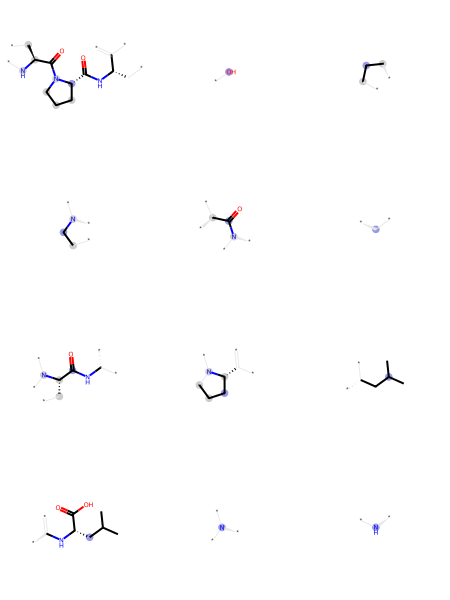

In [39]:
result_df = pd.read_csv('result.csv')
top_peptide = result_df["peptide"].values[0]
top_peptide_fp = list(result_df.iloc[0, 2:])
fp_keys = list(result_df.iloc[0, 2:].keys())

# top_peptide_fpの中で1のものを取得
top_peptide_fp = [fp_keys[i] for i, fp in enumerate(top_peptide_fp) if fp == 1]
print(top_peptide_fp)
# top_peptide_fpを全部intにする
top_peptide_fp = [int(fp) for fp in top_peptide_fp]

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
bitInfo_morgan = {}
fp_morgan = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromFASTA(top_peptide), 4, 4096, bitInfo=bitInfo_morgan)

print(bitInfo_morgan)

filtered_bitInfo_morgan = {bit : bitInfo_morgan[bit] for bit in top_peptide_fp}

print(filtered_bitInfo_morgan)

# 可視化
morgan_turples = ((Chem.MolFromFASTA(top_peptide), bit, bitInfo_morgan) for bit in top_peptide_fp)
Draw.DrawMorganBits(morgan_turples, molsPerRow=3)


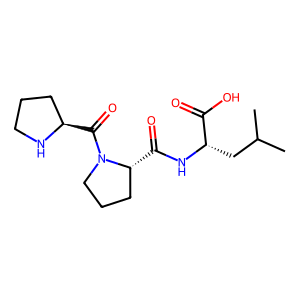

In [40]:
# ペプチドの構造を描画
Draw.MolToImage(Chem.MolFromFASTA(top_peptide))

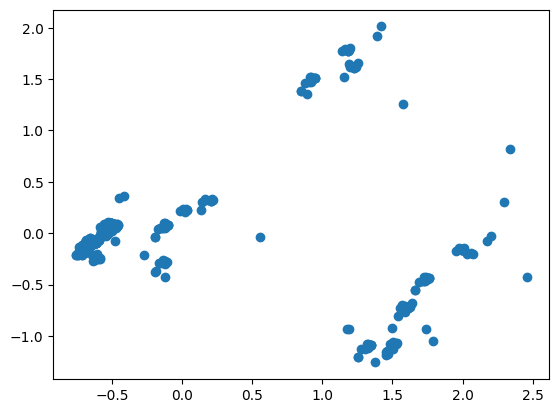

In [66]:
# 上位の配列を主成分分析
from sklearn.decomposition import PCA
import pandas as pd

result_df = pd.read_csv('result.csv')
# 値が0.6以上のものを取得
high_score_peptides = result_df[result_df["result"] >= 0.6]

feats = high_score_peptides.iloc[:, 2:]
pca = PCA(n_components=2)

pca.fit(feats)
feats_pca = pca.transform(feats)

high_score_peptides["x"] = feats_pca[:, 0]
high_score_peptides["y"] = feats_pca[:, 1]

import matplotlib.pyplot as plt

plt.scatter(feats_pca[:, 0], feats_pca[:, 1])
plt.show()

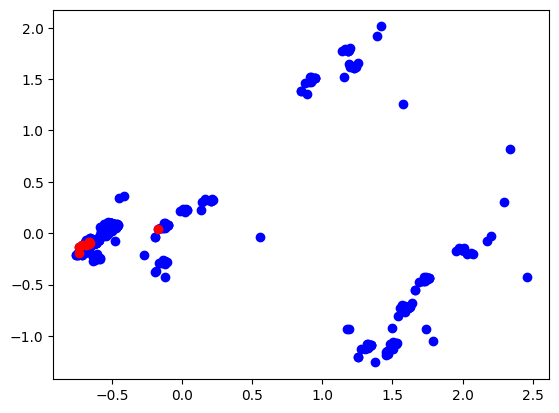

In [68]:
# 配列によるクラスタリングの可視化をしてみる

# 文字を分割する。1文字目と2文字目、2文字目と3文字目の組み合わせを作成
array_high_score_peptides = high_score_peptides["peptide"].values
array_high_score_peptides = [list(peptide) for peptide in array_high_score_peptides]
array_high_score_peptides = [[peptide[i] + peptide[i+1] for i in range(len(peptide)-1)] for peptide in array_high_score_peptides]
array_high_score_peptides = [item for sublist in array_high_score_peptides for item in sublist]

# 出現したジペプチドの数をカウントしてランクづけ
from collections import Counter
count = Counter(array_high_score_peptides)

# 主成分分析に、上位10個が含まれてる配列に色をつけて可視化
import matplotlib.pyplot as plt

result_df = pd.read_csv('result.csv')
# 値が0.6以上のものを取得
high_score_peptides = result_df[result_df["result"] >= 0.6]

feats = high_score_peptides.iloc[:, 2:]
pca = PCA(n_components=2)

pca.fit(feats)
feats_pca = pca.transform(feats)

high_score_peptides["x"] = feats_pca[:, 0]
high_score_peptides["y"] = feats_pca[:, 1]

import matplotlib.pyplot as plt

plt.scatter(feats_pca[:, 0], feats_pca[:, 1], c='blue')
plt.scatter(feats_pca[:, 0][:10], feats_pca[:, 1][:10], c='red')
plt.show()
